In [1]:
import numpy as np
import random

# TÍNH ĐỘ DÀI QUÃNG ĐƯỜNG
def path_distance(path, dist_matrix):
    total = 0
    for i in range(len(path) - 1):
        total += dist_matrix[path[i]][path[i+1]]
    total += dist_matrix[path[-1]][path[0]]  # quay lại thành phố đầu
    return total

# PSO CHO TSP
def pso_tsp(dist_matrix, n_particles=50, max_iter=200, w=0.8, c1=1.5, c2=1.5):
    n_cities = len(dist_matrix)
    
    # 1. Khởi tạo ngẫu nhiên các hạt (các chuỗi thành phố)
    swarm = [random.sample(range(n_cities), n_cities) for _ in range(n_particles)]
    
    # 2. Tính chi phí (độ dài đường đi) ban đầu
    costs = [path_distance(p, dist_matrix) for p in swarm]
    
    # 3. pBest: vị trí tốt nhất từng hạt
    pbest = list(swarm)
    pbest_cost = list(costs)
    
    # 4. gBest: vị trí toàn cục tốt nhất
    gbest = pbest[np.argmin(pbest_cost)]
    gbest_cost = min(pbest_cost)
    
    # 5. Lặp đến max_iter
    for t in range(max_iter):
        for i in range(n_particles):
            xi = swarm[i]
            vi = []

            # (7) Cập nhật "vận tốc" (trong TSP, vận tốc là phép hoán đổi)
            r1, r2 = random.random(), random.random()
            
            # Chọn ngẫu nhiên 2 điểm để hoán đổi, theo hướng pbest và gbest
            new_x = xi.copy()
            if random.random() < w:  # quán tính
                pass  # giữ nguyên
            if random.random() < c1 * r1:
                # Đưa dần xi gần về pbest
                swap_index = random.randint(0, n_cities-1)
                city_to_move = pbest[i][swap_index]
                idx = new_x.index(city_to_move)
                new_x[swap_index], new_x[idx] = new_x[idx], new_x[swap_index]
            if random.random() < c2 * r2:
                # Đưa dần xi gần về gbest
                swap_index = random.randint(0, n_cities-1)
                city_to_move = gbest[swap_index]
                idx = new_x.index(city_to_move)
                new_x[swap_index], new_x[idx] = new_x[idx], new_x[swap_index]
            
            # (9–11) Cập nhật vị trí & đảm bảo hợp lệ
            swarm[i] = new_x
            
            # (12) Tính chi phí mới
            new_cost = path_distance(new_x, dist_matrix)
            
            # (13–14) Cập nhật pBest
            if new_cost < pbest_cost[i]:
                pbest[i] = new_x
                pbest_cost[i] = new_cost
                
                # (16–17) Cập nhật gBest
                if new_cost < gbest_cost:
                    gbest = new_x
                    gbest_cost = new_cost
        
        # (20) Cập nhật w (giảm dần theo thời gian, tùy chọn)
        w = 0.9 - (0.5 * (t / max_iter))
    
    # (22) Trả về lời giải tốt nhất
    return gbest, gbest_cost

# TEST
if __name__ == "__main__":
    # Tạo dữ liệu 6 thành phố ngẫu nhiên trong không gian 2D
    np.random.seed(0)
    cities = np.random.rand(6, 2) * 100

    # Tính ma trận khoảng cách
    dist_matrix = np.linalg.norm(cities[:, None] - cities[None, :], axis=2)

    # Gọi PSO
    best_path, best_cost = pso_tsp(dist_matrix, n_particles=30, max_iter=200)

    print("Best path:", best_path)
    print("Best cost:", best_cost)


Best path: [0, 3, 2, 1, 4, 5]
Best cost: 158.72913444428463


Iteration 0: Best cost = 568.63
Iteration 20: Best cost = 488.88
Iteration 40: Best cost = 488.88
Iteration 60: Best cost = 488.88
Iteration 80: Best cost = 488.88
Iteration 100: Best cost = 488.88
Iteration 120: Best cost = 488.88
Iteration 140: Best cost = 488.88
Iteration 160: Best cost = 488.88
Iteration 180: Best cost = 488.88

Best path found: [5, 1, 0, 3, 2, 6, 7, 9, 4, 8]
Best cost: 488.8762904285211


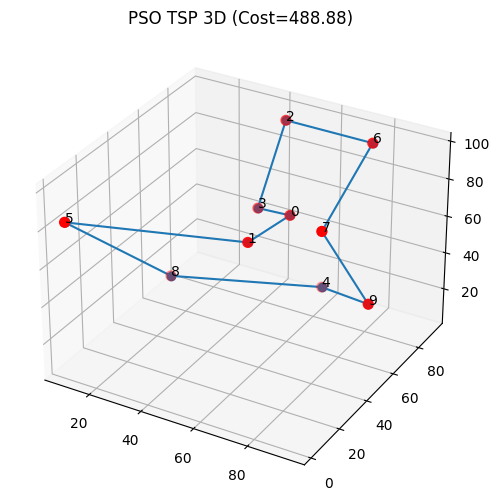

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# HÀM TÍNH KHOẢNG CÁCH ĐƯỜNG ĐI (TSP)
def path_distance(path, dist_matrix):
    total = 0
    for i in range(len(path) - 1):
        total += dist_matrix[path[i]][path[i+1]]
    total += dist_matrix[path[-1]][path[0]]  # quay lại điểm đầu
    return total


# HÀM SINH CHUỖI HOÁN ĐỔI GIỮA 2 HOÁN VỊ(Hướng di chuyển của hạt trong không gian vector)
def get_swap_sequence(A, B):
    seq = []
    temp = A.copy()
    for i in range(len(A)):
        if temp[i] != B[i]:
            j = temp.index(B[i])
            seq.append((i, j))
            temp[i], temp[j] = temp[j], temp[i]
    return seq


# ÁP DỤNG VẬN TỐC (CÁC HOÁN ĐỔI)
def apply_velocity(position, velocity):
    new_pos = position.copy()
    for (i, j) in velocity:
        new_pos[i], new_pos[j] = new_pos[j], new_pos[i]
    return new_pos


# THUẬT TOÁN PSO CHO TSP 3D

def pso_tsp_3d(coords, n_particles=40, max_iter=200, w=0.8, c1=1.5, c2=1.5):
    n_cities = len(coords)
    dist_matrix = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)
    
    # 1. Khởi tạo đàn ngẫu nhiên
    swarm = [random.sample(range(n_cities), n_cities) for _ in range(n_particles)]
    velocities = [[] for _ in range(n_particles)]  # danh sách swap
    
    # 2. Tính chi phí ban đầu
    costs = [path_distance(p, dist_matrix) for p in swarm]
    pbest = list(swarm)
    pbest_cost = list(costs)
    
    # 3. Xác định gBest
    gbest = pbest[np.argmin(pbest_cost)]
    gbest_cost = min(pbest_cost)
    
    # 4. Vòng lặp chính
    for t in range(max_iter):
        for i in range(n_particles):
            xi = swarm[i]
            vi = velocities[i]

            # --- Cập nhật vận tốc ---
            v_new = []
            
            # (a) Giữ lại 1 phần quán tính
            n_keep = int(w * len(vi))
            v_new.extend(vi[:n_keep])
            
            # (b) Hướng về pBest
            if random.random() < c1:
                seq_pb = get_swap_sequence(xi, pbest[i])
                v_new.extend(random.sample(seq_pb, k=min(len(seq_pb), 2)))
            
            # (c) Hướng về gBest
            if random.random() < c2:
                seq_gb = get_swap_sequence(xi, gbest)
                v_new.extend(random.sample(seq_gb, k=min(len(seq_gb), 2)))
            
            velocities[i] = v_new

            # --- Cập nhật vị trí ---
            new_x = apply_velocity(xi, v_new)
            swarm[i] = new_x

            # --- Tính chi phí ---
            new_cost = path_distance(new_x, dist_matrix)
            
            # --- Cập nhật pBest ---
            if new_cost < pbest_cost[i]:
                pbest[i] = new_x
                pbest_cost[i] = new_cost
                
                # --- Cập nhật gBest ---
                if new_cost < gbest_cost:
                    gbest = new_x
                    gbest_cost = new_cost
        
        # (optional) Giảm dần quán tính theo thời gian
        w = 0.9 - 0.5 * (t / max_iter)

        # Hiển thị tiến trình
        if t % 20 == 0:
            print(f"Iteration {t}: Best cost = {gbest_cost:.2f}")
    
    return gbest, gbest_cost

# DRAW
def plot_path_3d(coords, path, title="Best path"):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    path_coords = coords[path + [path[0]]]
    ax.plot(path_coords[:,0], path_coords[:,1], path_coords[:,2], '-o')
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], c='red', s=50)
    for i, (x, y, z) in enumerate(coords):
        ax.text(x, y, z, str(i))
    ax.set_title(title)
    plt.show()

# TEST
if __name__ == "__main__":
    np.random.seed(0)
    n_cities = 10
    coords = np.random.rand(n_cities, 3) * 100  # mỗi thành phố có x, y, z
    
    best_path, best_cost = pso_tsp_3d(coords, n_particles=50, max_iter=200)
    
    print("\nBest path found:", best_path)
    print("Best cost:", best_cost)
    
    plot_path_3d(coords, best_path, title=f"PSO TSP 3D (Cost={best_cost:.2f})")


Iteration 0: Best cost = 563.85
Iteration 20: Best cost = 515.80
Iteration 40: Best cost = 489.09
Iteration 60: Best cost = 489.09
Iteration 80: Best cost = 489.09
Iteration 100: Best cost = 489.09
Iteration 120: Best cost = 489.09
Iteration 140: Best cost = 489.09
Iteration 160: Best cost = 489.09
Iteration 180: Best cost = 489.09

Best path found: [0, 6, 2, 8, 7, 3, 1, 4, 5, 9]
Best cost: 489.0900229831135


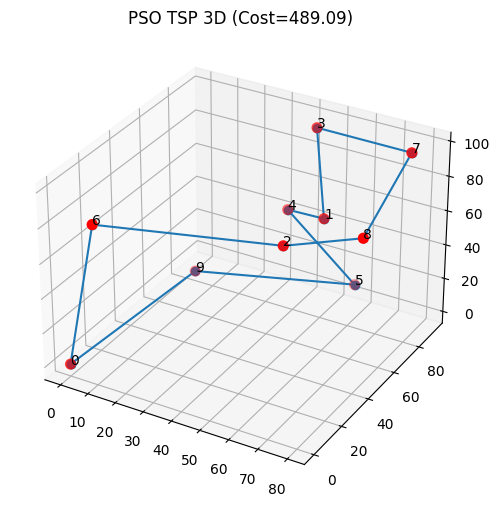

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json

# HÀM TÍNH KHOẢNG CÁCH ĐƯỜNG ĐI (TSP)
def path_distance(path, dist_matrix):
    total = 0
    for i in range(len(path) - 1):
        total += dist_matrix[path[i]][path[i+1]]
    total += dist_matrix[path[-1]][path[0]]  # quay lại điểm đầu
    return total


# HÀM SINH CHUỖI HOÁN ĐỔI GIỮA 2 HOÁN VỊ (Hướng di chuyển của hạt trong không gian vector)
def get_swap_sequence(A, B):
    seq = []
    temp = A.copy()
    for i in range(1, len(A)):  # bắt đầu từ 1 để không đổi vị trí thành phố 0
        if temp[i] != B[i]:
            j = temp.index(B[i])
            seq.append((i, j))
            temp[i], temp[j] = temp[j], temp[i]
    return seq


# ÁP DỤNG VẬN TỐC
def apply_velocity(position, velocity):
    new_pos = position.copy()
    for (i, j) in velocity:
        if i == 0 or j == 0:  # không bao giờ đổi chỗ thành phố 0
            continue
        new_pos[i], new_pos[j] = new_pos[j], new_pos[i]
    return new_pos


# THUẬT TOÁN PSO CHO TSP 3D (CÓ CỐ ĐỊNH THÀNH PHỐ 0)
def pso_tsp_3d(coords, n_particles=40, max_iter=200, w=0.8, c1=1.5, c2=1.5):
    n_cities = len(coords)
    dist_matrix = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)
    
    # 1. Khởi tạo đàn ngẫu nhiên — giữ cố định thành phố 0
    cities = list(range(1, n_cities))
    swarm = [[0] + random.sample(cities, len(cities)) for _ in range(n_particles)]
    velocities = [[] for _ in range(n_particles)]
    
    # 2. Tính chi phí ban đầu
    costs = [path_distance(p, dist_matrix) for p in swarm]
    pbest = list(swarm)
    pbest_cost = list(costs)
    
    # 3. Xác định gBest
    gbest = pbest[np.argmin(pbest_cost)]
    gbest_cost = min(pbest_cost)
    
    # 4. Vòng lặp chính
    for t in range(max_iter):
        for i in range(n_particles):
            xi = swarm[i]
            vi = velocities[i]

            # --- Cập nhật vận tốc ---
            v_new = []
            n_keep = int(w * len(vi))
            v_new.extend(vi[:n_keep])

            # (b) Hướng về pBest
            if random.random() < c1:
                seq_pb = get_swap_sequence(xi, pbest[i])
                v_new.extend(random.sample(seq_pb, k=min(len(seq_pb), 2)))

            # (c) Hướng về gBest
            if random.random() < c2:
                seq_gb = get_swap_sequence(xi, gbest)
                v_new.extend(random.sample(seq_gb, k=min(len(seq_gb), 2)))

            velocities[i] = v_new

            # --- Cập nhật vị trí ---
            new_x = apply_velocity(xi, v_new)
            swarm[i] = new_x

            # --- Tính chi phí ---
            new_cost = path_distance(new_x, dist_matrix)

            # --- Cập nhật pBest ---
            if new_cost < pbest_cost[i]:
                pbest[i] = new_x
                pbest_cost[i] = new_cost

                # --- Cập nhật gBest ---
                if new_cost < gbest_cost:
                    gbest = new_x
                    gbest_cost = new_cost
        
        # Giảm quán tính dần
        w = 0.9 - 0.5 * (t / max_iter)

        if t % 20 == 0:
            print(f"Iteration {t}: Best cost = {gbest_cost:.2f}")
    
    return gbest, gbest_cost

# MÔ PHỎNG ĐƯỜNG ĐI 3D
def plot_path_3d(coords, path, title="Best path"):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    path_coords = coords[path + [path[0]]]
    ax.plot(path_coords[:,0], path_coords[:,1], path_coords[:,2], '-o')
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], c='red', s=50)
    for i, (x, y, z) in enumerate(coords):
        ax.text(x, y, z, str(i))
    ax.set_title(title)
    plt.show()



# TEST - ĐỌC DỮ LIỆU TỪ FILE
if __name__ == "__main__":
    # Đọc dữ liệu
    with open("l:\\Tính toán tiến hóa\\IT4906_Project\\IT4906\\output_data_kmeans\\nodes_100.json", "r") as f:
        nodes_data = json.load(f)
    
    # Chuyển đổi sang numpy array
    coords = coords = np.array([cluster['center'] for cluster in nodes_data.values()])
    n_cities = len(coords)
    
    print(f"Đã đọc {n_cities} nodes từ file nodes_100.json")
    print(f"Tọa độ node đầu tiên: {coords[0]}")

    best_path, best_cost = pso_tsp_3d(coords, n_particles=50, max_iter=200)
    
    print("\nBest path found:", best_path)
    print("Best cost:", best_cost)
    
    plot_path_3d(coords, best_path, title=f"PSO TSP 3D (Cost={best_cost:.2f})")

/tmp/ipykernel_13/3289288940.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(traj[0, 0], traj[0, 1], traj[0, 2], c=colors[i], marker='o', s=40)  # điểm bắt đầu
/tmp/ipykernel_13/3289288940.py:57: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(traj[-1, 0], traj[-1, 1], traj[-1, 2], c=colors[i], marker='x', s=60)  # điểm kết thúc


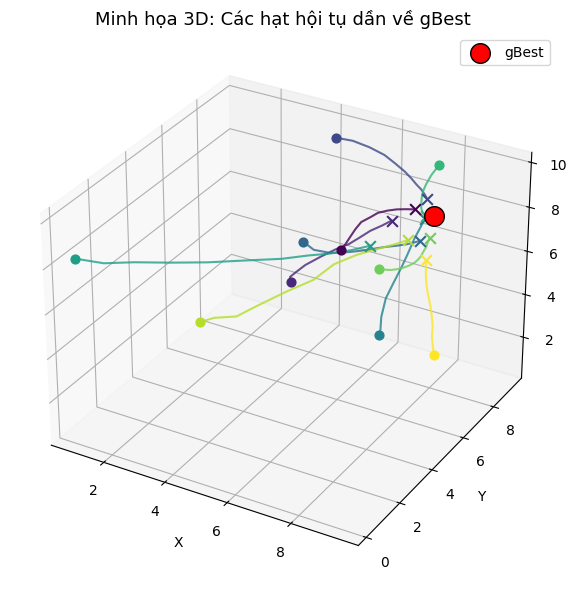

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json

# ===============================
# MÔ PHỎNG QUÁ TRÌNH PSO 3D VỚI DỮ LIỆU THỰC TẾ
# ===============================

# Đọc dữ liệu từ file nodes_100.json
with open("l:\\Tính toán tiến hóa\\IT4906_Project\\IT4906\\output_data_kmeans\\nodes_100.json", "r") as f:
    nodes_data = json.load(f)

# Chuyển đổi sang numpy array và lấy 10 nodes đầu tiên để minh họa
coords = coords = np.array([cluster['center'] for cluster in nodes_data.values()])[:10]
print(f"Sử dụng 10 nodes đầu tiên từ file nodes_100.json")
print(f"Phạm vi tọa độ: X[{coords[:,0].min():.1f}, {coords[:,0].max():.1f}], Y[{coords[:,1].min():.1f}, {coords[:,1].max():.1f}], Z[{coords[:,2].min():.1f}, {coords[:,2].max():.1f}]")

# Thiết lập hạt & không gian
n_particles = 10          # số lượng hạt
n_iter = 10               # số vòng lặp

# Vị trí ngẫu nhiên ban đầu của các hạt trong phạm vi dữ liệu thực
x_range = [coords[:,0].min(), coords[:,0].max()]
y_range = [coords[:,1].min(), coords[:,1].max()]
z_range = [coords[:,2].min(), coords[:,2].max()]

positions = np.random.uniform(
    [x_range[0], y_range[0], z_range[0]], 
    [x_range[1], y_range[1], z_range[1]], 
    (n_particles, 3)
)

# gBest sẽ là trung tâm của dữ liệu thực
gBest = np.mean(coords, axis=0)
print(f"gBest (trung tâm dữ liệu): [{gBest[0]:.1f}, {gBest[1]:.1f}, {gBest[2]:.1f}]")

# Tham số PSO
w, c1, c2 = 0.7, 1.5, 1.5

# Khởi tạo vận tốc ban đầu
velocities = np.random.randn(n_particles, 3) * 5  # scale vận tốc cho phù hợp

# Lưu lại quỹ đạo của từng hạt để vẽ
trajectories = [positions.copy()]

# Mô phỏng chuyển động của các hạt trong vài vòng lặp
for t in range(n_iter):
    r1, r2 = np.random.rand(n_particles, 3), np.random.rand(n_particles, 3)
    
    # Giả định pBest = vị trí hiện tại (đơn giản để minh họa)
    cognitive = c1 * r1 * (positions - positions)
    social = c2 * r2 * (gBest - positions)
    
    # Cập nhật vận tốc và vị trí (điều chỉnh hệ số cho phù hợp với dữ liệu)
    velocities = w * velocities + 0.1 * social
    positions = positions + 0.3 * velocities
    
    trajectories.append(positions.copy())

# ===============================
# VẼ 3D VỚI DỮ LIỆU THỰC
# ===============================

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.viridis(np.linspace(0, 1, n_particles))

# Vẽ quỹ đạo các hạt
for i in range(n_particles):
    traj = np.array([p[i] for p in trajectories])
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=colors[i], alpha=0.8, linewidth=2)
    ax.scatter(traj[0, 0], traj[0, 1], traj[0, 2], c=colors[i], marker='o', s=40)  # điểm bắt đầu
    ax.scatter(traj[-1, 0], traj[-1, 1], traj[-1, 2], c=colors[i], marker='x', s=60)  # điểm kết thúc

# Vẽ các nodes thực từ file
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], 
          color='blue', s=100, alpha=0.6, marker='^', label='Real Nodes')

# Đánh số các nodes thực
for i, (x, y, z) in enumerate(coords):
    ax.text(x, y, z, f'N{i}', fontsize=8)

# gBest (điểm đích)
ax.scatter(*gBest, color='red', s=200, edgecolor='black', label='gBest (Center)')

# Nhãn và tiêu đề
ax.set_title("Minh họa 3D: PSO với dữ liệu thực từ nodes_100.json", fontsize=13)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.tight_layout()
plt.show()